# Data Generation for Tutorials

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_theme()
%matplotlib widget

## Elution Curve Model

In [2]:
def gaussian(x, m, s, h):
    return h*np.exp(-((x - m)/s)**2)

## Scattering Curve Model
* [2010, B. Hammouda; A new Guinier-Porod model](https://journals.iucr.org/paper?ce5078)
* caveat: this model is only for tutorials, meaning not realistic as a protein model due to the lack of medium angle regions 

In [3]:
def guinier_porod(q, Rg, d, G, return_also_q1=False):
    q1 = 1/Rg*np.power(3*d/2, 1/2)
    D = G * np.exp(-q1**2 * Rg**2/3) * q1**d
    lower = q <= q1
    qlow = q[lower]
    qhigh = q[np.logical_not(lower)]
    low_angle_values = G * np.exp(-qlow**2*Rg**2/3)
    high_angle_values = D/qhigh**d
    w = np.concatenate([low_angle_values, high_angle_values])
    if return_also_q1:
        return w, q1
    else:
        return w

## Matrix Operation and 3D View
### Single Component

In [4]:
x = np.arange(300)
q = np.linspace(0.005, 0.5, 400)
def plot_single_component_data(Rg, d, G, m, s, h):
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133, projection='3d')
    
    w, q1 = guinier_porod(q, Rg, d, G, return_also_q1=True)
    # ax1.set_yscale('log')
    ax1.set_title("Scattering Curve: P")
    ax1.plot(q, w)
    ax1.axvline(q1, linestyle=':', color="green", label='Guinier-Porod $Q_1$')
    ax1.legend()

    y = gaussian(x, m, s, h)
    ax2.set_title("Elution Curve: C")
    ax2.plot(x, y)
    
    zz =  w.reshape((len(q),1)) @ y.reshape((1,len(x)))
    xx, qq = np.meshgrid(x, q)
    ax3.set_title("3D Data View: M=PC")
    ax3.plot_surface(qq, xx, zz)
    fig.tight_layout()

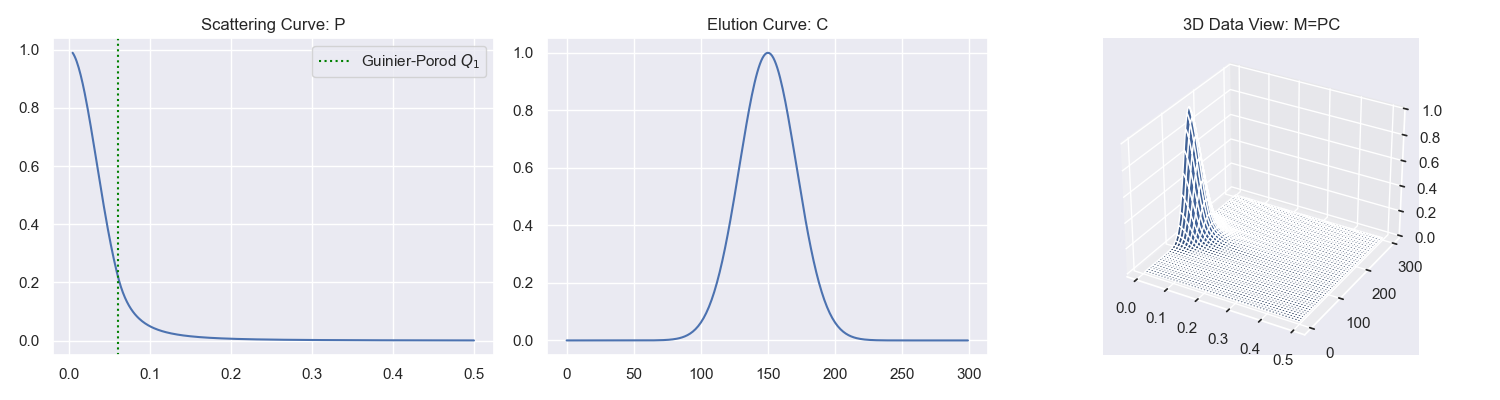

In [5]:
plot_single_component_data(35, 3, 1, 150, 30, 1)

### Multiple Components

In [6]:
def plot_multiple_component_data(scattering_params, elution_params, use_matrices=False):
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133, projection='3d')
    
    # ax1.set_yscale('log')
    ax1.set_title("Scattering Curve: P")
    w_list = []
    for Rg, d, G in scattering_params:
        w, q1 = guinier_porod(q, Rg, d, G, return_also_q1=True)
        w_list.append(w)
        ax1.plot(q, w)
        ax1.axvline(q1, linestyle=':', color="green", label='Guinier-Porod $Q_1$')
    ax1.legend()

    y_list = []
    ax2.set_title("Elution Curve: C")
    for m, s, h in elution_params:
        y = gaussian(x, m, s, h)
        y_list.append(y)
        ax2.plot(x, y)
        
    ax3.set_title("3D Data View: M=PC")
    xx, qq = np.meshgrid(x, q)
    if use_matrices:
        P = np.array(w_list).T
        C = np.array(y_list)
        M = P @ C
    else:
        zz_list = []
        for w, y in zip(w_list, y_list):
            zz =  w.reshape((len(q),1)) @ y.reshape((1,len(x)))
            zz_list.append(zz)
        M = np.sum(zz_list, axis=0)
    ax3.plot_surface(qq, xx, M)        
    fig.tight_layout()

    if use_matrices:
        return P, C, M

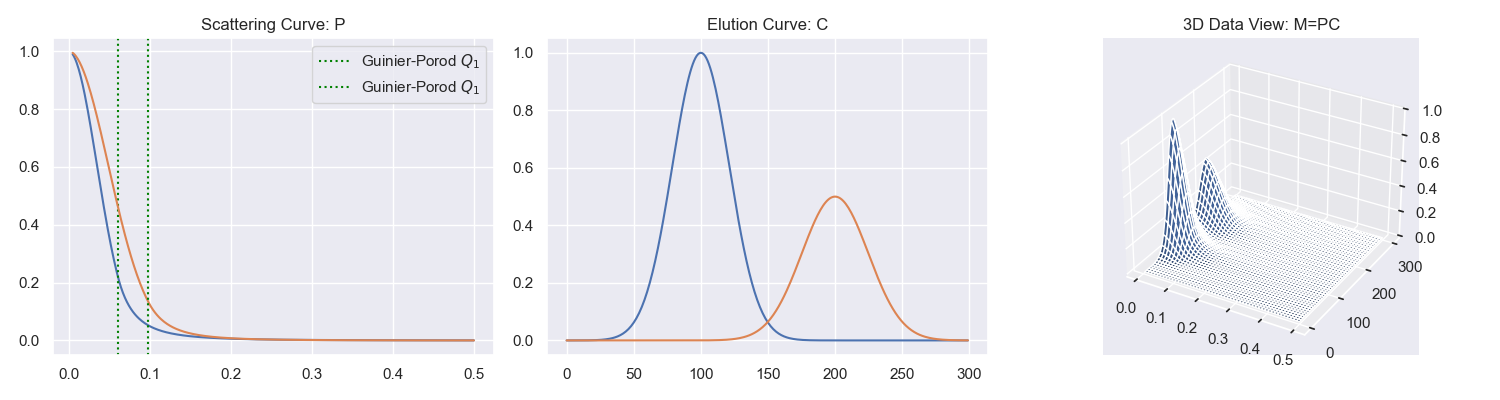

In [7]:
scattering_params = [(35, 3, 1), (25, 4, 1)]
elution_params = [(100, 30, 1), (200, 35, 0.5)]
plot_multiple_component_data(scattering_params, elution_params)

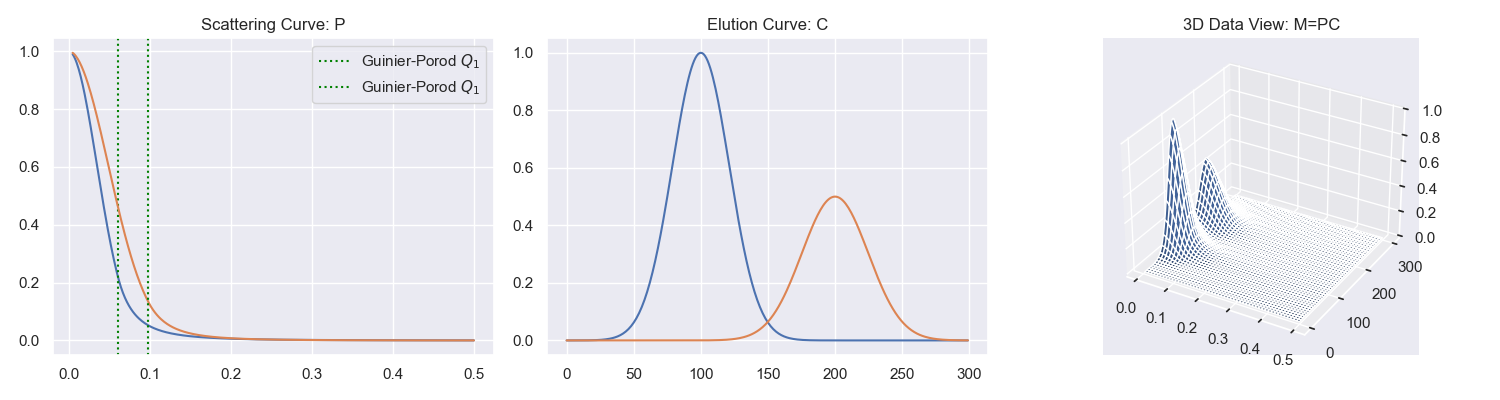

In [8]:
P, C, M = plot_multiple_component_data(scattering_params, elution_params, use_matrices=True)